# 2_TopicModeling

- Conducted topic modeling using LDA through Ktrain, initially setting the number of topics to 10. After this initial run, three topics related to AI were identified as being too general. Therefore, performed topic modeling again for the three AI-Related groups with the number of topics set to 10. 
- Additionally, topics with little relevance were grouped as noise(Other/Not Assigned). 
- As a result, as shown in the table on the right (Final Modeling), the news were divided into nine topics: Finance, Market Research, HealthCare, AIproduct_Cloud_Enterprise, ConversationalAI_LLM, Digital_Innovation, Google_Services, Chip_Computing, and CEO_Event_Regulation.
- In determining the content of the topics, representative news articles were also referenced. 
- Before executing the model, data cleaning steps were taken, including converting to lowercase, removing stopwords, and lemmatizing.

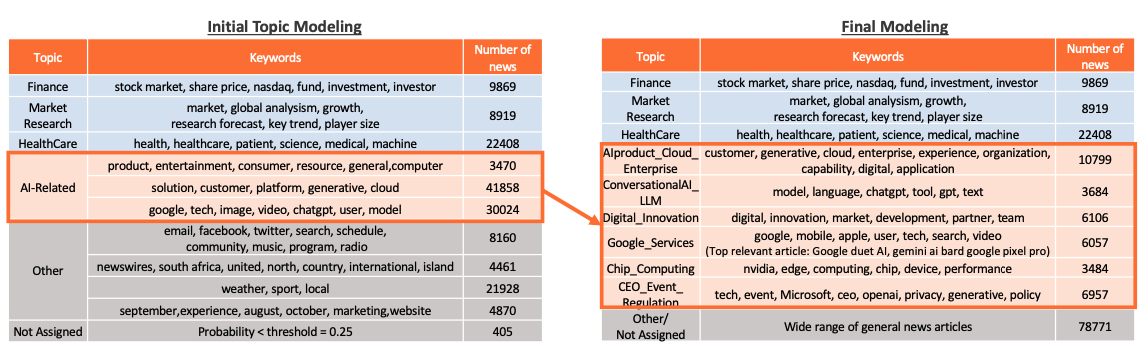

In [3]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import itertools
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
import random
import spacy
from spacy_langdetect import LanguageDetector
from spacy.language import Language
from collections import Counter
import gensim
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from pprint import pprint
import sys
import os
import tensorflow as tf
import re
import string
import nltk as nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import ktrain
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

import warnings
warnings.simplefilter('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
%%time

df = pd.read_parquet('cleaned_data.parquet', engine='pyarrow')
df.shape

CPU times: user 7.41 s, sys: 14.7 s, total: 22.1 s
Wall time: 22.8 s


(157054, 7)

In [ ]:
df.head()

,doc_id,url,date,language,title,text,token_count
0,1,http://galusaustralis.com/2020/02/486473/legaltech-artificial-intelligence-market-2019-technology-advancement-and-future-scope-casetext-inc-catalyst-repository-systems-ebrevia/,2020-02-26,en,LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope Casetext Inc. Catalyst Repository Systems eBREVIA Galus Australis,LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope Casetext Inc. Catalyst Repository Systems eBREVIA Galus Australis Galus Australis BusinessGeneral NewsHealthcareIndustryInternationalLifestyleSci-Tech Wednesday February 26 2020 Trending Needle Counters Market Comprehensive Study by Companies Medline Industries Boen Healthcare Skin Scrub Trays Market Comprehensive Study by Companies Medline Industries BD Deroyal Global Portable Handheld Electronic Game Mach...,935
1,2,http://newsparliament.com/2020/02/27/children-with-autism-saw-their-learning-and-social-skills-boosted-after-playing-with-this-ai-robot/,2020-02-27,en,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot News Parliament,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot News Parliament Skip to content Thursday February 27 2020 Latest Mansplaining in conferences How can we get him to forestall Drax power station to cease burning coal in March 2021 Coronavirus Could Explode in the U.S. Overnight Like it Did in Italy Coronavirus Dettol sales surge as markets fall again Levi Strauss marks the next phase in corporate paid leave policies News Parliament Get the Real...,1557
4,3,http://www.millenniumpost.in/big-stories/ai-express-aircraft-skids-off-runaway-in-kozhikode-rescue-ops-on-414926,2020-08-07,en,Two dead as AI Express flight skids off Kozhikode airport,Two dead as AI Express flight skids off Kozhikode airportTopLoginSubscribeToggle navigationFeaturesDelhiKolkataNationOpinionEditorialBusinessSportsSunday PostBeyond BygoneEpic PowerIn RetrospectGlobal EyeInlandRoutesBeaconInsightGame OnSafariTrendingCandid TalkGastronomyFact FilesMapping the states of IndiaXsunday-postbeyond-bygonesunday-postepic-powerfact-filesians-feedssundaypostin-retrospectmapping-the-states-of-indiapuja-specialReminiscencesponsoredsundaypostglobal-eyefeaturesnationworld...,263
5,4,http://www.nativestew.com/2023/11/ai-took-my-job.html,2023-11-20,en,Native Stew - Bahamas AI Art Photos Videos AI Took My Job,Native Stew - Bahamas AI Art Photos Videos AI Took My Job Pages Home People Places Things Monday November 20 2023 AI Took My Job AI Took My Job - AI artA. Derek Catalano at November 20 2023 Email ThisBlogThisShare to TwitterShare to FacebookShare to Pinterest Labels Art People Newer Post Older Post Home Go Fund Me My daughter-in-law Gayle. Please help. Translate About Me A. Derek Catalano Photos videos and art featuring the people places and things of The Bahamas. I've traveled to many islan...,328
8,5,http://www.sbwire.com/press-releases/healthcare-artificial-intelligence-market-next-big-thing-major-giants-general-electric-medtronic-aicure-apixio-1363690.htm,2022-10-06,en,Healthcare Artificial Intelligence Market Analysis and Forecast for Next 5 Years,Healthcare Artificial Intelligence Market Analysis and Forecast for Next 5 Years SBWire Sign Up Login Our Service Plans Pricing Newsroom Help About AMA Research amp Media LLP Email Alerts RSS Healthcare Artificial Intelligence Market Next Big Thing Major Giants- General Electric Medtronic AiCure APIXIO Healthcare Artificial Intelligence Market 2022-2028 New Jersey USA -- SBWIRE -- 10052022 -- Advance Market Analytics published a new research publication on Healthcare Artificial Intelligence ...,780


In [ ]:
df['title'][0]

'LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope Casetext Inc. Catalyst Repository Systems eBREVIA Galus Australis'

In [ ]:
df['text'][0]

'LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope Casetext Inc. Catalyst Repository Systems eBREVIA Galus Australis Galus Australis BusinessGeneral NewsHealthcareIndustryInternationalLifestyleSci-Tech Wednesday February 26 2020 Trending Needle Counters Market Comprehensive Study by Companies Medline Industries Boen Healthcare Skin Scrub Trays Market Comprehensive Study by Companies Medline Industries BD Deroyal Global Portable Handheld Electronic Game Machine Market Outlook and Business Insights 2020-2026 Apollo Games Sony Aristocrat Leisure IGT Infectious Disease Testing Using PCR for IVD Market Comprehensive Study by Companies Thermo Fisher BD Roche Diagnostics Veterinary Dental X-ray Generators Market Comprehensive Study by Companies Planmeca Midmark Medicatech USA Veterinary Ophthalmoscopes Market Comprehensive Study by Companies Heine Optotechnik Gowllands Limited Veterinary Holters Market Comprehensive Study by Companies Dextronix Nasiff Assoc

In [ ]:
# Cleaning for topic modeling

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    """
    Cleans text by:
    - Removing special characters and numbers.
    - Converting to lowercase.
    - Removing stopwords.
    - Lemmatizing the words to their base form.
    Returns a single string representing the cleaned text.
    """

    # Remove special characters and numbers
    text = re.sub(r'[^A-Za-z\s]', '', text)

    # Convert to lowercase
    text = text.lower()

    # Remove stopwords and lemmatize
    words = text.split()
    cleaned_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    # Return the cleaned text as a single string
    return ' '.join(cleaned_words)

In [ ]:
# Clean the 'text' and 'title' column
df['text_cleaned'] = df['text'].apply(clean_text)
df['title_cleaned'] = df['title'].apply(clean_text)

In [ ]:
# Append the content of 'title' to 'text'
df['text_cleaned'] = df['text_cleaned'] + " " + df['title_cleaned']

It is believed that the information in the title is already included in the text. However, since the title may contain content that should be emphasized, 'title+text' will be analyzed.

In [ ]:
texts = df['text_cleaned'].tolist()

## Initial topic modeling

Start with 10 topics. Unlike class assignments, since it's a dataset of around 160K entries, set min_df not as an absolute number but as a percentage (0.1%).

In [ ]:
# starting with n=10

%%time
tm = ktrain.text.get_topic_model(
    texts=texts,
    n_topics=10,
    n_features=10000,
    min_df=0.001,
    max_df=0.5,
    stop_words='english',
    model_type='lda',
    lda_max_iter=5,
    verbose=1)

lang: en
preprocessing texts...
fitting model...
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
done.
CPU times: user 21min 10s, sys: 1min 52s, total: 23min 2s
Wall time: 21min 25s


In [ ]:
tm.print_topics()

topic 0 | email facebook republic twitter search schedule community music program radio
topic 1 | law south newswires africa united north country international island press
topic 2 | stock market share price nasdaq fund investment investor financial bank
topic 3 | market global analysis growth research forecast key trend player size
topic 4 | product entertainment consumer resource general health energy overview computer cision
topic 5 | health research human patient learning science model medical healthcare machine
topic 6 | gray solution customer platform press generative cloud alert prnewswire statement
topic 7 | google tech like image video chatgpt india user best model
topic 8 | ago hour video day story weather sport say app local
topic 9 | marketing website best user cooky online september experience august october


In [ ]:
%%time
tm.build(texts, threshold=0.25)

done.
CPU times: user 5min 38s, sys: 18.5 s, total: 5min 57s
Wall time: 5min 43s


In [ ]:
tm.print_topics(show_counts=True)

topic:6 | count:41858 | gray solution customer platform press generative cloud alert prnewswire statement
topic:7 | count:30024 | google tech like image video chatgpt india user best model
topic:5 | count:22408 | health research human patient learning science model medical healthcare machine
topic:8 | count:21928 | ago hour video day story weather sport say app local
topic:2 | count:9869 | stock market share price nasdaq fund investment investor financial bank
topic:3 | count:8919 | market global analysis growth research forecast key trend player size
topic:0 | count:8160 | email facebook republic twitter search schedule community music program radio
topic:9 | count:4870 | marketing website best user cooky online september experience august october
topic:1 | count:4461 | law south newswires africa united north country international island press
topic:4 | count:3470 | product entertainment consumer resource general health energy overview computer cision


In [ ]:
# Display the text of the most relevant document for each topic ID from 0 to 9.
for topic_id in range(10):
    # Retrieve documents related to each topic and display the text of the most relevant document.
    print(f"Top document for Topic {topic_id}:")
    print(tm.get_docs(topic_ids=[topic_id], rank=True)[0]['text'][:2000])
    print("\n")

Top document for Topic 0:
artist ai weiwei father exile hope son maine public search query show search home news deep dive rural maine reporting project maine political pulse podcast day maine podcast maine public connecting community maine maine cdc briefing podcast maine public news connect nation business economy politics environment outdoors health court crime art culture political pulse weekly email newsletter ten weekly email newsletter daily email newsletter deep dive rural maine reporting project maine political pulse podcast day maine podcast maine public connecting community maine maine cdc briefing podcast maine public news connect nation business economy politics environment outdoors health court crime art culture political pulse weekly email newsletter ten weekly email newsletter daily email newsletter radio maine public radio schedule experience magazine program guide hear maine public radio maine calling music move thing considered morning edition podcast shortlist day m

In [1]:
doc_topics=tm.get_doctopics()
tm.visualize_documents(doc_topics=tm.get_doctopics())

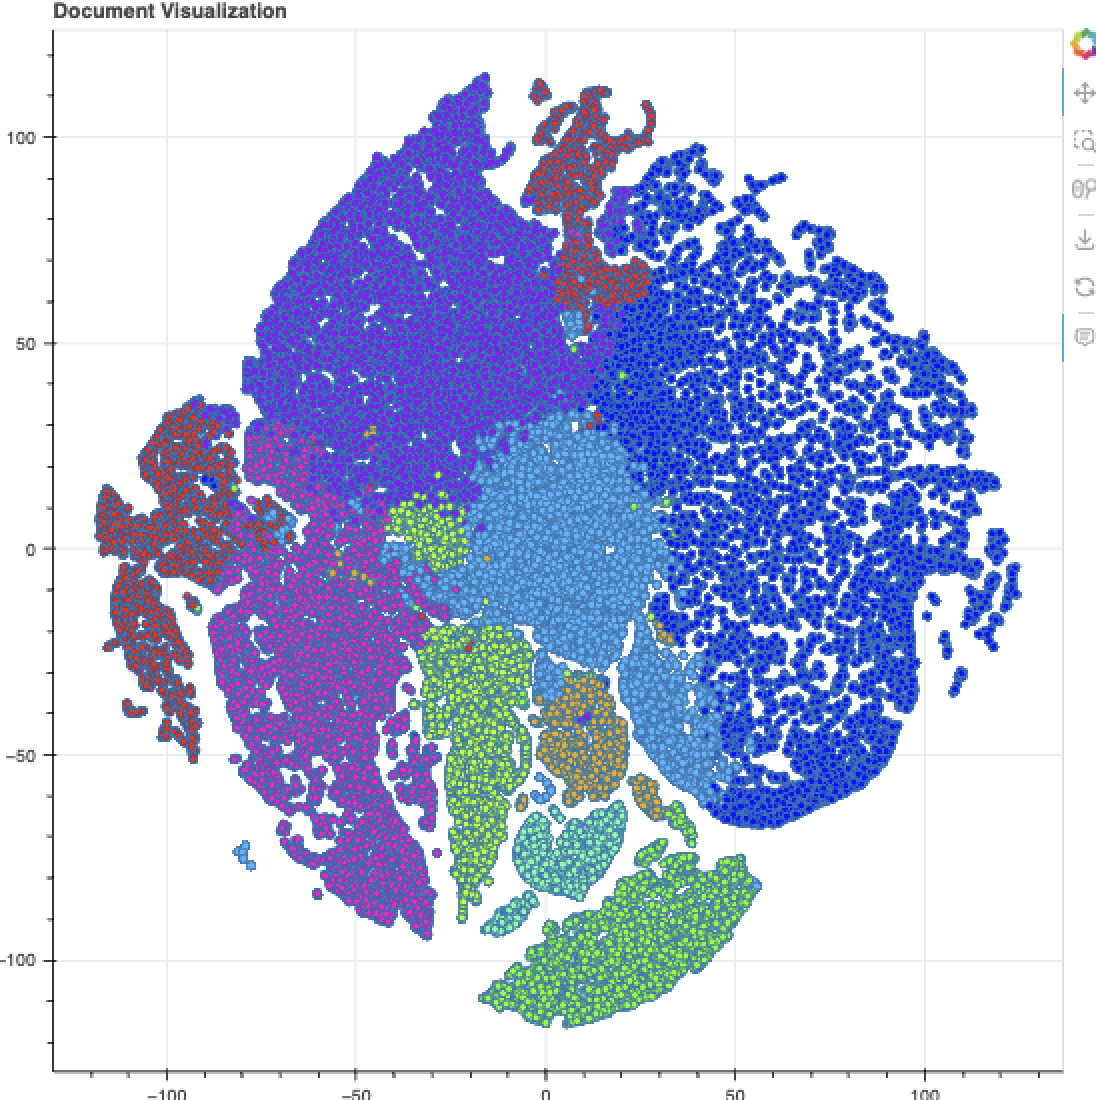

In [ ]:
# Get the topic probability distribution
topic_probs = tm.predict(texts)

# Set the threshold
threshold = 0.25

# Prepare an empty list for topic assignments
topic_assignments = []

# For each document, select the most probable topic and check if it exceeds the threshold
for probs in topic_probs:
    top_topic = np.argmax(probs)  # Select the most probable topic
    if probs[top_topic] >= threshold:  # If the probability of that topic is above the threshold
        topic_assignments.append(top_topic)  # Assign the topic
    else:
        topic_assignments.append(None)  # Assign None if below threshold

# Add a new column to the dataframe containing the predicted topic indices
df['topic'] = topic_assignments

In [ ]:
# Replace NaN values in the 'topic' column with 'other'
df['topic'] = df['topic'].fillna('other')

# Convert all values in the 'topic' column to strings
df['topic'] = df['topic'].astype(str)

In [ ]:
# The number of news for each topic
df['topic'].value_counts()

6.0      41858
7.0      30024
5.0      22408
8.0      21928
2.0       9869
3.0       8919
0.0       8160
9.0       4870
1.0       4461
4.0       3470
other     1087
Name: topic, dtype: int64

## Comments - 1

Based on the results, I divided them into three groups as follows. Only topics that need further division(2.) are extracted and subjected to topic modeling again using ktain.

1. Topics that seem meaningful are confirmed.
2. Topics that need further division
3. Topics that do not seem to have much relevance are assigned as "other" (unused Topics).

1. Meaningful Topics

- TOPIC 2: Finance  
Words such as stock market, share price, nasdaq, fund, investment, investor are observed, appearing to be related to Finance.
Representative News Articles are also related. Looking at the figure (the bright yellow-green group just below the light blue), it can be seen that the Topic is well organized.

- TOPIC 3: Market Research  
Words such as market, global analysis, growth, research forecast, key trend, player size are observed, appearing to be related to market research (reports, etc.).
Representative News Articles are also related.　Looking at the figure (the green group at the bottom), it can be seen that the TOPIC is well organized and somewhat separated from the other TOPICS.

- TOPIC 5: Healthcare  
Words such as health, healthcare, patient, science, medical, machine are observed, appearing to be related to Healthcare.
Representative News Articles are also related.　Looking at the figure (the central light blue group), it can be seen that the TOPIC is well organized.

2. Topics that Need Further Division

- TOPIC 4: AI-related  
AI-related words such as product, entertainment, consumer, resource, general, computer are observed, but it is not possible to identify a specific detail Topic. Also, terms like health and energy are present, making the industry unclear.  
Representative News Article states 'aetina launch new system platform powered nvidia jetson agx orin nextgeneration ai computer vision application,' suggesting a relation to AI.  
Looking at the figure (the light blue group below brown), it can be seen that the Topic is organized and independent.  

- TOPIC 6: AI-related  
AI-related words such as solution, customer, platform, generative, cloud are observed, but it is not possible to identify a specific detail Topic.  
Representative News Article includes generative ai and vertex ai platform, suggesting a relation to AI.  
Looking at the figure (the blue group in the top right), it can be seen that the TOPIC is broadly spread, and due to the large number of samples, further division is necessary.  

- TOPIC 7: AI-related  
AI-related words such as google, tech, image, video, chatgpt, user, model are observed, but it is not possible to identify a specific detail Topic.  
Representative News Articles include topics like samsung galaxy, google smartphones smartwatches, generative ai, live translate, large language models, suggesting the possibility of being related to devices or LLMs.  
Looking at the figure (the purple group in the top left), it can be seen that the TOPIC is reasonably organized, but due to the large number of samples, further division is warranted.  

3. Topics with Little Relevance

- TOPIC 0  
Words like email, facebook, twitter, search, schedule, community, music, program, radio are lined up, which seem like they would commonly accompany online news articles.  
Representative News Articles also consist of general news, appearing unrelated to AI.  
Looking at the figure (the red group on the left), it can be seen that the Topic is somewhat separated.  

- TOPIC 1  
Words related to international matters such as newswires, south africa, united, north, country, international, island are observed.  
Representative News Articles consist of these words, and the relation to AI seems weak.  
Looking at the figure (the brown group), it can be seen that the Topic is organized and independent.  

- TOPIC 8  
Keywords like weather, sport, local are lined up, suggesting a weak relation to AI.  
Looking at Representative News Articles, general topics such as entertainment, weather, incidents are lined up, showing no strong relation to AI.  
Looking at the figure (the pink group), it can be seen that the Topic is broadly scattered and lacks cohesion.  

- TOPIC 9  
Words like marketing, website might seem related to AI at first glance, but september, experience, august, october do not show a strong relation to AI.  
Looking at Representative News Articles, information on ForexTV, marketing, foreign exchange is lined up, showing no strong relation to AI. The content might be dominated by advertised information.  
Looking at the figure (the red group at the top), it can be seen that it is reasonably organized. Since the number is also small, it is excluded.  

## 2. Further Topic Modeling

In [9]:
filtered_df = df[df['topic'].isin(['4.0', '6.0', '7.0'])]

In [10]:
filtered_df.shape

(75352, 10)

In [27]:
texts = filtered_df['text_cleaned'].tolist()

In [28]:
# starting with n=10

%%time
tm = ktrain.text.get_topic_model(
    texts=texts,
    n_topics=10,
    n_features=10000,
    min_df=0.001,
    max_df=0.5,
    stop_words='english',
    model_type='lda',
    lda_max_iter=5,
    verbose=1)

lang: en
preprocessing texts...
fitting model...
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
done.
CPU times: user 8min 38s, sys: 10.8 s, total: 8min 49s
Wall time: 8min 45s


In [29]:
tm.print_topics()

topic 0 | customer generative cloud enterprise experience organization capability digital application management
topic 1 | entertainment consumer policy resource general health cision overview financial overviewview
topic 2 | model language user chatgpt tool result learning forwardlooking gpt text
topic 3 | global digital innovation market development risk energy management partner team
topic 4 | tech event google microsoft startup ceo openai privacy generative policy
topic 5 | gray alert weather station inspection endorsed courtesy reflect necessarily health
topic 6 | nvidia edge computing chip device performance support application storage video
topic 7 | india sport video share indian story latest live entertainment health
topic 8 | like image people say human work way video art using
topic 9 | google best review feature mobile apple user tech search video


In [30]:
%%time
tm.build(texts, threshold=0.25)

done.
CPU times: user 2min 21s, sys: 2.31 s, total: 2min 23s
Wall time: 2min 23s


In [31]:
tm.print_topics(show_counts=True)

topic:5 | count:17728 | gray alert weather station inspection endorsed courtesy reflect necessarily health
topic:8 | count:11548 | like image people say human work way video art using
topic:0 | count:10799 | customer generative cloud enterprise experience organization capability digital application management
topic:4 | count:6957 | tech event google microsoft startup ceo openai privacy generative policy
topic:3 | count:6106 | global digital innovation market development risk energy management partner team
topic:9 | count:6057 | google best review feature mobile apple user tech search video
topic:7 | count:5115 | india sport video share indian story latest live entertainment health
topic:2 | count:3684 | model language user chatgpt tool result learning forwardlooking gpt text
topic:6 | count:3484 | nvidia edge computing chip device performance support application storage video
topic:1 | count:3469 | entertainment consumer policy resource general health cision overview financial overview

In [33]:
# Display the text of the most relevant document for each topic ID from 0 to 9.
for topic_id in range(10):
    # Retrieve documents related to each topic and display the text of the most relevant document.
    print(f"Top document for Topic {topic_id}:")
    print(tm.get_docs(topic_ids=[topic_id], rank=True)[0]['text'][:2000])
    print("\n")

Top document for Topic 0:
genesys introduces ai experience complete way business orchestrate unique customer journey skip contentavera medical minutelocal guidesomeone knowtouchstone energy scholar weekhomeweathersportssubmit itlivestreamlatest newscastscovid updateshomenewsagriculturecrimeeconomyeducationentertainmentinternationalnationalmaking differenceregionalsciencestatetechnologylivestreamweatherinteractive radarsioux fallsnortheast sdcentral sddelays cancellationsskycam networkmap roomroad conditionssportsscoreboardathlete weekplay weekpigskin previewpoliticselection resultsmorningmr foodowning outdoorscommunityshop weekavera medical minutecontact usmeet teamcareers dakota news nowcareers graycommunity calendarcontestsvideolocal guideadvertise usag marketscovid updatescovid mapsomeone knowprogramming schedulesubmit photo videogray dc bureauinvestigate tvpowernationcircle country music lifestylelatest newscastspress releasesgenesys introduces ai experience complete way business o

In [40]:
# Display the text of the second most relevant document for each topic ID from 0 to 9.
for topic_id in range(10):
    # Retrieve documents related to each topic and display the text of the second most relevant document.
    print(f"Top document for Topic {topic_id}:")
    print(tm.get_docs(topic_ids=[topic_id], rank=True)[1]['text'][:2000])
    print("\n")

Top document for Topic 0:
pega infinity enhanced new ai automation capability power autonomous enterprise skip contentnewsweatherhurricane guidetrafficsportscalendarsouth florida weekendwatch livesavvy contestswatch livehomenewsnationalentertainmentweatherhurricane guidesouth florida weekendsavvy contestssportsstats predictionshow watchabout uscontact usnextgen tvprogramming schedulelatest newscastsyour photo platform submit sharepowernationcircle country music lifestylegray dc bureauinvestigatetvpress releasespega infinity enhanced new ai automation capability power autonomous enterprisepublished jun edtupdated hour agoinnovations help enterprise accelerate development optimize process create effortless experience employee customerslas vega june prnewswire pegasystems inc nasdaq pega lowcode platform provider empowering world leading enterprise build change today announced pegaworld inspire annual conference latest edition pega infinity software suite new feature accelerate lowcode de

In [2]:
doc_topics=tm.get_doctopics()
tm.visualize_documents(doc_topics=tm.get_doctopics())

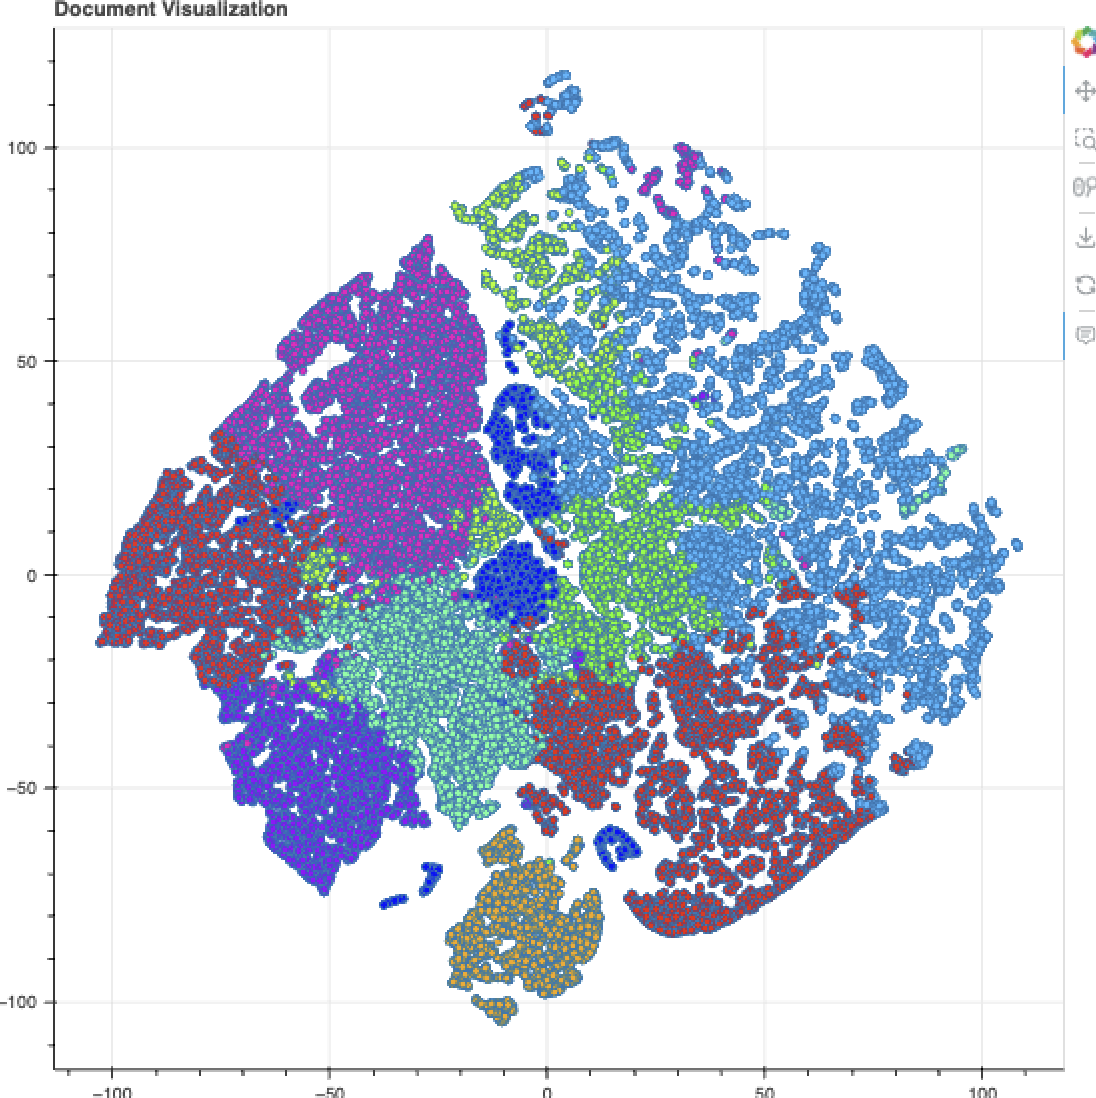

In [46]:
# Get the topic probability distribution
topic_probs = tm.predict(texts)

# Set the threshold
threshold = 0.25

# Prepare an empty list for topic assignments
topic_assignments = []

# For each document, select the most probable topic and check if it exceeds the threshold
for probs in topic_probs:
    top_topic = np.argmax(probs)  # Select the most probable topic
    if probs[top_topic] >= threshold:  # If the probability of that topic is above the threshold
        topic_assignments.append(top_topic)  # Assign the topic
    else:
        topic_assignments.append(None)  # Assign None if below threshold

# Add a new column to the dataframe containing the predicted topic indices
filtered_df['topic2'] = topic_assignments

In [47]:
# Replace NaN values in the 'topic' column with 'other'
filtered_df['topic2'] = filtered_df['topic2'].fillna('other')

# Convert all values in the 'topic' column to strings
filtered_df['topic2'] = filtered_df['topic2'].astype(str)

In [48]:
filtered_df['topic2'].value_counts()

5.0      17728
8.0      11548
0.0      10799
4.0       6957
3.0       6106
9.0       6057
7.0       5115
2.0       3684
6.0       3484
1.0       3469
other      405
Name: topic2, dtype: int64

## Comments - 2

Firstly, looking at the figure, the light blue area in the top right (TOPIC 5) is widely spread. The other TOPICS are somewhat organized.　　

- TOPIC 0: AIproduct_Cloud_Enterprise  
This topic includes many words and articles related to AI services and products, especially cloud services that promote automation for enterprises.

- TOPIC 1: other  
Due to the lack of consistency in keywords, both top articles being noise information with little relevance to AI, and the small sample size, this topic is excluded as "other."

- TOPIC 2: ConversationalAI_LLM  
Words such as model, language, chatgpt, tool, gpt, text suggest that the articles are related to Conversational AI and LLMs, including ChatGPT. This is consistent with the content of typical News Articles.

- TOPIC 3: Digital_Innovation  
From the key words and articles, this topic is presumed to be related to promoting digitalization using AI. The word "risk" appears, but from looking at the articles, it seems to be used in the context of mitigating risks and increasing efficiency, which aligns with Digital Innovation.

- TOPIC 4: CEO_Event_Regulation  
Keywords such as tech, event, google, microsoft, startup, ceo, openai, privacy, generative, policy suggest news articles are often about technology-related events where CEOs of major companies and regulators discuss policies related to AI. Looking at typical News Articles, there are mentions of EU regulators and AI legislation. Prominent figures include openai ceo sam altman, and there are also articles related to Elon Musk's OpenAI, suggesting it's not solely about Regulation. The figure shows it is organized (the light green in the center-left bottom).

- TOPIC 5: other  
"Gray" is included as a keyword, indicating noise from the name Gray Media Group. Also, the typical topic confirmed includes general news like weather forecasts, leading to the detection of 'weather' as a word. While it may contain articles related to AI, the presence of noise leads to its exclusion.

- TOPIC 6: Chip_Computing  
Keywords include nvidia, edge computing, chip, device, performance, support, application, storage, video, suggesting it's a topic related to Chips and Computing. The figure shows it is organized (the blue in the center).

- TOPIC 7: other (India)  
There is a lot of information related to India, with other keywords like sport, video, share, story, latest, live, entertainment, health being generally related to news. Articles are unrelated to AI, indicating a high possibility of noise, hence it is excluded as "other."

- TOPIC 8: other  
Keywords are general and broad, including image, people, say, human, work, way, video, art. TOP Articles are unrelated to AI, indicating a high possibility of noise, hence it is excluded as "other."

- TOPIC 9: Google_Services  
Keywords like google, mobile, apple, user, tech, search, video suggest services related to companies like Google and Apple might be highly related to AI. TOP Articles include Google duet AI, gemini ai bard google pixel pro, showing a strong relation to Google. A review of some TOP articles shows no strong relation to Apple, likely suggesting articles are written in relation to Google services and possibly Apple, iPhone (mobile). For caution, it is broadly categorized as Google_Services.

## 3. Topic Labelling and Sava data

In [53]:
# Define a dictionary to map topic numbers to topic names
topic_mapping = {
    '0.0': 'other',
    '1.0': 'other',
    '2.0': 'Finance',
    '3.0': 'MarketResearch',
    '4.0': 'topic2',
    '5.0': 'HealthCare',
    '6.0': 'topic2',
    '7.0': 'topic2',
    '8.0': 'other',
    '9.0': 'other',
    'other': 'other'
}

# Map the topic numbers to topic names in the 'topic' column
df['topic'] = df['topic'].map(topic_mapping)

In [58]:
# Define a dictionary to map topic numbers to topic names
topic2_mapping = {
    "0.0": "AIproduct_Cloud_Enterprise",
    "1.0": "other",
    "2.0": "ConversationalAI_LLM",
    "3.0": "Digital_Innovation",
    "4.0": "CEO_Event_Regulation",
    "5.0": "other",
    "6.0": "Chip_Computing",
    "7.0": "other",
    "8.0": "other",
    "9.0": "Google_Services",
    "other": "other"
}

# Map the topic numbers to topic names in the 'topic2' column
filtered_df['topic2'] = filtered_df['topic2'].map(topic2_mapping)

In [74]:
# Merge data
merged_df = df.merge(filtered_df[['doc_id', 'topic2']], on='doc_id', how='left')

In [75]:
merged_df.loc[merged_df['topic'] == 'topic2', 'topic'] = merged_df.loc[merged_df['topic'] == 'topic2', 'topic2']

In [76]:
# Topic Count
merged_df['topic'].value_counts()

other                         78771
HealthCare                    22408
AIproduct_Cloud_Enterprise    10799
Finance                        9869
MarketResearch                 8919
CEO_Event_Regulation           6957
Digital_Innovation             6106
Google_Services                6057
ConversationalAI_LLM           3684
Chip_Computing                 3484
Name: topic, dtype: int64

In [77]:
# Total Count
merged_df['topic'].value_counts().sum()

157054

In [80]:
merged_df = merged_df[['doc_id','topic']]

In [82]:
merged_df.head()

,doc_id,topic
0,1,MarketResearch
1,2,HealthCare
2,3,other
3,4,other
4,5,MarketResearch


In [83]:
# Specify the file path where the Parquet file will be saved
file_path = 'topicmodeling.parquet'

# Save the DataFrame as a Parquet file
merged_df.to_parquet(file_path)